# Model Results Consumer

This scratch pad consumes the Kafka topic that has run models. Consume the results and make them look nice

In [55]:
import json
import datetime
from keras.models import model_from_json
from kafka import KafkaConsumer

import matplotlib.pyplot as plt

%matplotlib inline

In [102]:
def model_training_duration(result):
    "Calculates the number of minutes the training took"
    
    if type(result) != dict:
        return None
    
    #if not result.get('training_time_end', False) or result.get('training_time_start', False):
    #    return None
    
    pformat = '%Y-%m-%dT%H:%M:%S.%f'
    tdiff = (datetime.datetime.strptime(result['training_time_end'], pformat) - datetime.datetime.strptime(result['training_time_start'], pformat))
    return tdiff.seconds / 60


In [12]:
# To consume latest messages and auto-commit offsets
consumer = KafkaConsumer('test-model-results',
                         group_id='test-group-001',
                         client_id='test-consumer-001',
                         bootstrap_servers=['spark4.thedevranch.net'],
                         #value_deserializer=lambda m: json.loads(m.decode('utf-8')),
                         auto_offset_reset='earliest',
                         enable_auto_commit=False,
                        )

results = []
for message in consumer:
    # message value and key are raw bytes -- decode if necessary!
    # e.g., for unicode: `message.value.decode('utf-8')`
    print("%s:%d:%d: key=%s" % (message.topic, message.partition,
                                message.offset, message.key,
                                          ))
    results.append(message.value.decode('utf-8'))

test-model-results:0:0: key=None
test-model-results:0:1: key=None
test-model-results:0:2: key=None
test-model-results:0:3: key=None
test-model-results:0:4: key=None
test-model-results:0:5: key=None
test-model-results:0:6: key=None
test-model-results:0:7: key=None
test-model-results:0:8: key=None
test-model-results:0:9: key=None
test-model-results:0:10: key=None
test-model-results:0:11: key=None
test-model-results:0:12: key=None
test-model-results:0:13: key=None


KeyboardInterrupt: 

In [111]:
[len(json.loads(result)['config']) for result in results]

[10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 16, 16, 7, 7]

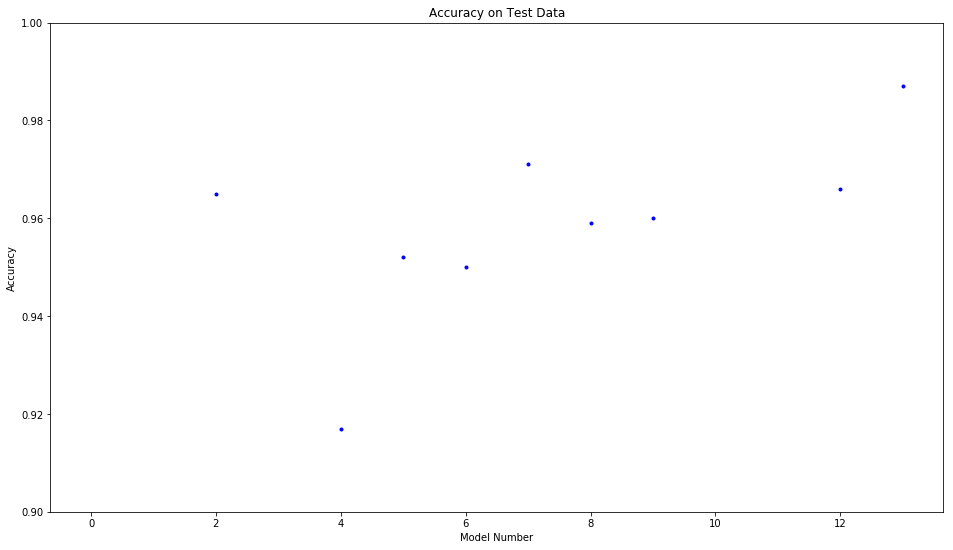

In [114]:
training_times = []
test_accs = []

for result in results:
    result = json.loads(result)
    training_times.append( model_training_duration(result) )
    test_accs.append(result['acc'])

plt.figure(figsize=(16,9))
plt.plot(test_accs, 'b.')

plt.ylim((0.9, 1.0))
plt.title("Accuracy on Test Data")
plt.ylabel("Accuracy")
plt.xlabel("Model Number")
plt.show()

## Single Model Analysis

In [16]:
result = json.loads(results[11])
result

{'acc': 0.489,
 'backend': 'tensorflow',
 'batch_size': 128,
 'class_name': 'Sequential',
 'config': [{'class_name': 'Conv2D',
   'config': {'activation': 'relu',
    'activity_regularizer': None,
    'batch_input_shape': [None, 240, 320, 1],
    'bias_constraint': None,
    'bias_initializer': {'class_name': 'Zeros', 'config': {}},
    'bias_regularizer': None,
    'data_format': 'channels_last',
    'dilation_rate': [1, 1],
    'dtype': 'float32',
    'filters': 8,
    'kernel_constraint': None,
    'kernel_initializer': {'class_name': 'VarianceScaling',
     'config': {'distribution': 'uniform',
      'mode': 'fan_avg',
      'scale': 1.0,
      'seed': None}},
    'kernel_regularizer': None,
    'kernel_size': [3, 3],
    'name': 'conv_1',
    'padding': 'same',
    'strides': [1, 1],
    'trainable': True,
    'use_bias': True}},
  {'class_name': 'MaxPooling2D',
   'config': {'data_format': 'channels_last',
    'name': 'max_pool_1',
    'padding': 'same',
    'pool_size': [2, 2],


In [52]:
model = model_from_json( json.dumps(result))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_1 (Conv2D)              (None, 240, 320, 8)       80        
_________________________________________________________________
max_pool_1 (MaxPooling2D)    (None, 120, 160, 8)       0         
_________________________________________________________________
dropout_42 (Dropout)         (None, 120, 160, 8)       0         
_________________________________________________________________
conv_2 (Conv2D)              (None, 120, 160, 16)      1168      
_________________________________________________________________
max_pool_2 (MaxPooling2D)    (None, 60, 80, 16)        0         
_________________________________________________________________
dropout_43 (Dropout)         (None, 60, 80, 16)        0         
_________________________________________________________________
conv_3 (Conv2D)              (None, 60, 80, 32)        4640      
__________

In [80]:
pformat = '%Y-%m-%dT%H:%M:%S.%f'
tdiff = (datetime.datetime.strptime(result['training_time_end'], pformat) - datetime.datetime.strptime(result['training_time_start'], pformat))
print("Model training time: %s minutes" % model_training_duration(result))

Model training time: 47.8 minutes


In [53]:
# test acc
result['acc']

0.489

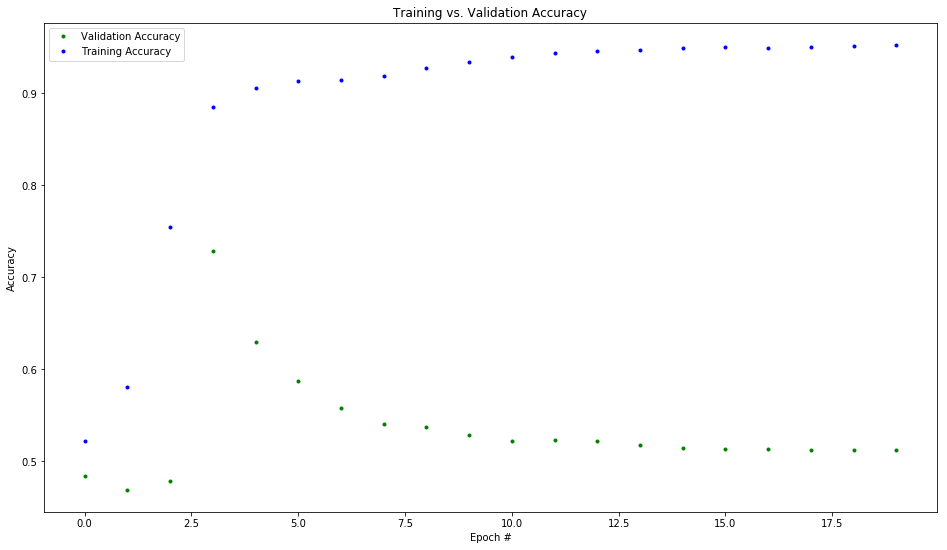

In [32]:
hx = result['history']
plt.figure(figsize=(16,9))

plt.plot(hx['val_acc'], 'g.', label="Validation Accuracy")
plt.plot(hx['acc'], 'b.', label="Training Accuracy")

plt.title("Training vs. Validation Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [39]:
[arch['class_name'] for arch in result['config']]

['Conv2D',
 'MaxPooling2D',
 'Dropout',
 'Conv2D',
 'MaxPooling2D',
 'Dropout',
 'Conv2D',
 'MaxPooling2D',
 'Dropout',
 'Conv2D',
 'MaxPooling2D',
 'Dropout',
 'Flatten',
 'Dense',
 'Dropout',
 'Dense']